In [ ]:
import os
import PIL.Image
import weave
import numpy as np
import PIL
import matplotlib.pyplot as plt

os.environ['WANDB_API_KEY'] = "bdc8857f9d6f7010cff35bcdc0ae9413e05c75e1"
weave.init('aghiles-kebaili/federated-pet') # 🐝

input_image = np.load('./data/13_16_33.npy')
input_image = input_image[input_image.shape[0] // 2]

input_image = input_image / input_image.max()
input_image = input_image + np.random.normal(0, 0.1, input_image.shape)

cmap = plt.get_cmap('hot')
input_image = cmap(input_image)
input_image = (input_image[:, :, :3] * 255).astype(np.uint8)
input_image = PIL.Image.fromarray(input_image)

@weave.op() # 🐝 Decorator to track requests
def testing_weave(input_image: PIL.Image) -> PIL.Image:
    # ... generating output image ...
    # outputing the generating image as PIL image
    output_image = input_image
    return output_image

testing_weave(input_image)


### Je check les valeurs SUV (max, min, moyenne)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_Nifti/'

subjects = os.listdir(ROOT)[:100]
placeholder = np.zeros(shape=(subjects.__len__(), 3), dtype=np.float32)

for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # filtering only PT images
        if not img_name.startswith('PT') or 'EARL' in img_name:
            continue

        img_path = os.path.join(subject_path, img_name)
        img_nii = nib.load(img_path).get_fdata()
        
        placeholder[s, 0] = img_nii.min()
        placeholder[s, 1] = img_nii.max()
        placeholder[s, 2] = img_nii.mean()
    
        
    


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [47]:
rand_indices = np.random.choice(subjects.__len__(), size=10, replace=False)
for idx in rand_indices:
    print(f"Subject: {subjects[idx]}, Min: {placeholder[idx, 0]}, Max: {placeholder[idx, 1]}, Mean: {placeholder[idx, 2]}")

Subject: 9401190790m, Min: 0.0, Max: 12.866623878479004, Mean: 0.023959901183843613
Subject: 9401189726m, Min: 0.0, Max: 24.14497947692871, Mean: 0.026275796815752983
Subject: 9401186744m, Min: 0.0, Max: 19.535802841186523, Mean: 0.0661429688334465
Subject: 9401170220m, Min: 0.0, Max: 4.9171833992004395, Mean: 0.03137609735131264
Subject: 9401167786m, Min: 0.0, Max: 14.460616111755371, Mean: 0.021418126299977303
Subject: 9401168770m, Min: 0.0, Max: 13.302177429199219, Mean: 0.027970507740974426
Subject: 9401154302m, Min: 0.0, Max: 4.757358074188232, Mean: 0.024020418524742126
Subject: 9401171676m, Min: 0.0, Max: 18.70843505859375, Mean: 0.03658916801214218
Subject: 9401164896m, Min: 0.0, Max: 5.504562854766846, Mean: 0.0263146311044693
Subject: 9401164485m, Min: 0.0, Max: 4.946689605712891, Mean: 0.0276942141354084


### Testing the MIP Dataset class

In [6]:
import torch
import numpy as np
from modules.data import MIPDataset

dataset = MIPDataset(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    random_crop_size=(128, 128),
    horizontal_flip=0.5,
    vertical_flip=0.5,
    dtype='float32'
)
dataset

In [7]:
for idx in range(dataset.__len__()):
    sample = dataset[idx]
    print(f"Sample {idx}: Image shape: {sample['image'].shape}, Dtype: {sample['image'].dtype}")

Sample 0: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 1: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 2: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 3: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 4: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 5: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 6: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 7: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 8: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 9: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 10: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 11: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 12: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 13: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sa

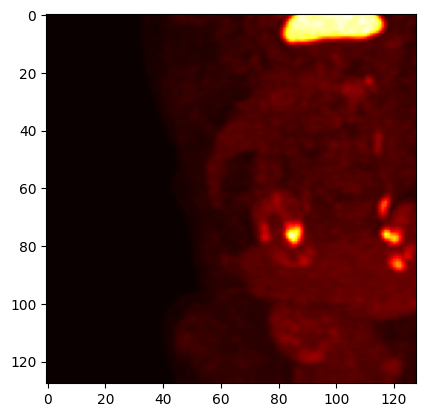

In [22]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0]['image'].squeeze(), cmap='hot')

In [38]:
from modules.data import MIPDataModule
from modules.utils import set_seed

set_seed(43)

datamodule = MIPDataModule(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    train_ratio=0.9,
    batch_size=8,
    num_workers=4,
    random_crop_size=(128, 128)
)

datamodule.prepare_data()
datamodule.setup()

datamodule.train_dataset.paths

Seed set to 43


Seed set to 43 with deterministic=False
Discovered 19 MIP files under ./data/federated-pet/Ano_Nifti/ with pattern 'pt_teptapac_ano_mip'
  Training samples: 17
  Validation samples: 2


['./data/federated-pet/Ano_Nifti/9401154964m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154754m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154325m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154744m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154752m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154749m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154756m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154763m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154742m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154314m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154753m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154750m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154305m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/An

### Deleting MIP files

In [162]:
import os
from tqdm import tqdm

ROOT = '../datasets/EARL/Rennes_Nifti/'
subjects = os.listdir(ROOT)
for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # deleting MIP images, files containing 'MIP' in their names
        if 'MIP' in img_name:
            img_path = os.path.join(subject_path, img_name)
            os.remove(img_path)

100%|██████████| 77/77 [00:00<00:00, 13631.09it/s]


### Testing the VAE

In [4]:
from modules.models.autoencoders import VariationalAutoencoder
from omegaconf import OmegaConf
import torch

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

model = VariationalAutoencoder.load_from_checkpoint('./runs/patch-reconstruction-model-64x64/2025_11_21_152448/last.ckpt')
model = model.eval()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work_p11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work_p11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
from modules.data import MIPDataset, MIPDataModule
from omegaconf import OmegaConf

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

config['datamodule']['root'] = '../datasets/EARL/Rennes_Nifti/'
config['datamodule']['pattern'] = '_AC_MIP'
config['datamodule']['train_ratio'] = 0.02  # Use all data for validation/testing

datamodule = MIPDataModule(**config['datamodule'])
datamodule.prepare_data()
datamodule.setup()

val_paths = datamodule.val_dataset.paths

validation_dataset = MIPDataset(
    paths=val_paths,
    cache_after_load=True,
    normalize=True,
    dtype='float32'
)

Discovered 77 MIP files under ../datasets/EARL/Rennes_Nifti/ with pattern '_ac_mip'
  Training samples: 1
  Validation samples: 76


MIP Image metadata: (torch.Size([1, 1, 447, 200]), 1.0241057872772217, 1.8432823419570923)


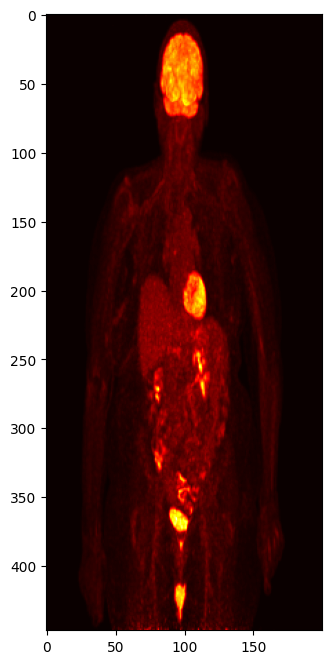

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sample = validation_dataset[np.random.randint(validation_dataset.__len__())]
random_mip_image = sample['image'].unsqueeze(0).to(model.device)
mean, std = sample['mean'], sample['std']
print('MIP Image metadata: {}'.format((random_mip_image.shape, mean, std)))

plt.figure(figsize=(2 * int(random_mip_image.shape[-2] // 100), 4 * int(random_mip_image.shape[-1] // 100)))
plt.imshow(random_mip_image.squeeze().cpu(), cmap='hot')
plt.show()

In [38]:
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def sliding_inference(model, mip, patch_size, stride, mean, std, verbose=False):
    _, _, H, W = mip.shape

    # compute steps and padded sizes
    x_steps = (max(0, W - patch_size)) // stride + 1
    y_steps = (max(0, H - patch_size)) // stride + 1
    padded_w = stride * (x_steps - 1) + patch_size
    padded_h = stride * (y_steps - 1) + patch_size
    pad_w = padded_w - W
    pad_h = padded_h - H

    padded_mip = mip
    if pad_h > 0 or pad_w > 0:
        padded_mip = np.pad(mip, ((0, pad_h),(0, pad_w)), mode='constant', constant_values=0.0)

    # prepare accumulators
    accum = torch.zeros_like(padded_mip, dtype=torch.float64)
    counts = torch.zeros_like(padded_mip, dtype=torch.float32)

    # build counts matrix as in your example
    for xi in range(x_steps):
        for yi in range(y_steps):
            x_start = xi * stride
            y_start = yi * stride
            counts[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size] += 1.0

    # sliding inference
    progress = tqdm(total=x_steps * y_steps, position=0, leave=True) if verbose else None
    for xi in range(x_steps):
        for yi in range(y_steps):
            x_start = xi * stride
            y_start = yi * stride
            true_patch = padded_mip[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size]

            with torch.no_grad():
                pred_patch = model.forward(true_patch)
            
            accum[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size] += pred_patch
        
            if progress is not None:
                progress.update(1)

    # average
    counts[counts == 0] = 1.0
    recon_norm = accum / counts
    recon_norm = recon_norm[:, :, :H, :W]
    recon = recon_norm * std + mean

    true = mip[:, :, :H, :W] * std + mean    

    assert recon.shape[2] == true.shape[2] and recon.shape[3] == true.shape[3], \
    "Reconstructed and true images have different shapes: {} : {}".format(recon.shape, true.shape)

    return recon, recon_norm, true

# infering all Rennes samples
samples = list()
for mip in tqdm(validation_dataset, position=0, leave=True, total=validation_dataset.__len__()):
    recon_mip, recon_norm_mip, true_mip = sliding_inference(
        model, 
        mip['image'].unsqueeze(0).to(model.device),
        patch_size=64,
        stride=16,
        mean=mip['mean'],
        std=mip['std'],
        verbose=False
    )

    samples.append({
        'recon_mip': recon_mip.cpu().squeeze().numpy(),
        'recon_norm_mip': recon_norm_mip.cpu().squeeze().numpy(),
        'true_mip': true_mip.cpu().squeeze().numpy()
    })

100%|██████████| 76/76 [01:49<00:00,  1.44s/it]


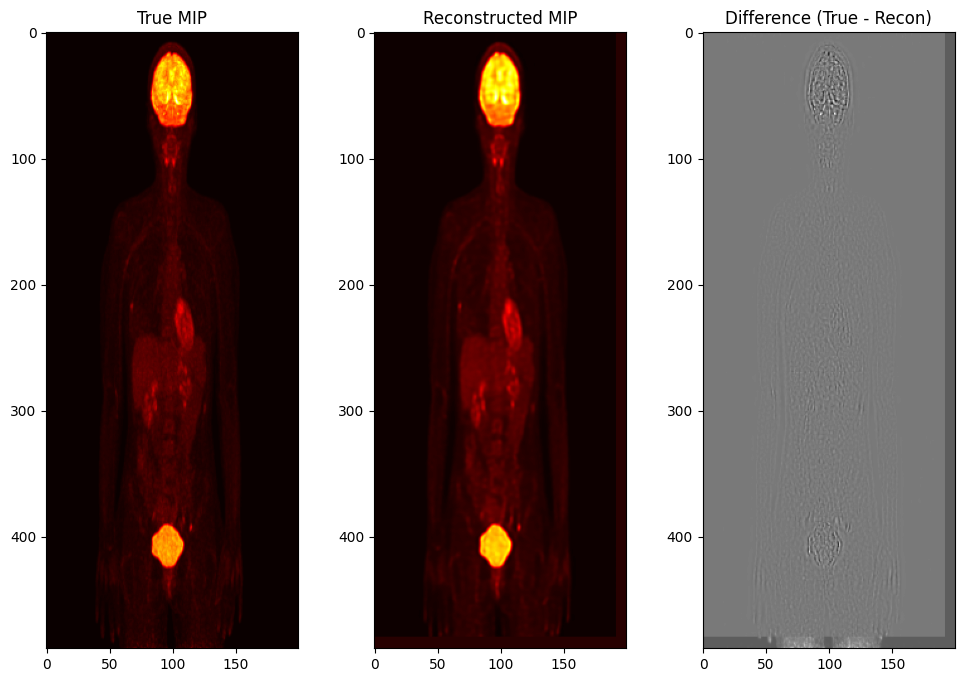

In [49]:
# display with matplotlib difference between true and reconstructed MIP at index 0

import matplotlib.pyplot as plt
idx = 2
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title('True MIP')
plt.imshow(samples[idx]['true_mip'], cmap='hot')
plt.subplot(1, 3, 2)
plt.title('Reconstructed MIP')
plt.imshow(samples[idx]['recon_mip'], cmap='hot')
plt.subplot(1, 3, 3)
plt.title('Difference (True - Recon)')
plt.imshow(samples[idx]['true_mip'] - samples[idx]['recon_mip'], cmap='gray')
plt.show()

In [40]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# compute ssim and psnr between recon_mip and true_mip
# for each patient
for p in tqdm(samples, position=0, leave=True, total=samples.__len__()):
    psnr_metric = PeakSignalNoiseRatio(data_range=p['true_mip'].max() - p['true_mip'].min())
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=p['true_mip'].max() - p['true_mip'].min())

    psnr = psnr_metric(
        torch.tensor(p['recon_mip']).unsqueeze(0).unsqueeze(0), 
        torch.tensor(p['true_mip']).unsqueeze(0).unsqueeze(0)
    ).item()
    ssim = ssim_metric(
        torch.tensor(p['recon_mip']).unsqueeze(0).unsqueeze(0), 
        torch.tensor(p['true_mip']).unsqueeze(0).unsqueeze(0)
    ).item()

    p['psnr'] = psnr
    p['ssim'] = ssim

100%|██████████| 76/76 [00:09<00:00,  8.26it/s]


In [42]:
print(np.mean([p['psnr'] for p in samples]), np.std([p['psnr'] for p in samples]))
print(np.mean([p['ssim'] for p in samples]), np.std([p['ssim'] for p in samples]))

43.4289093519512 5.084591836287654
0.9492137965403105 0.02594244017310826


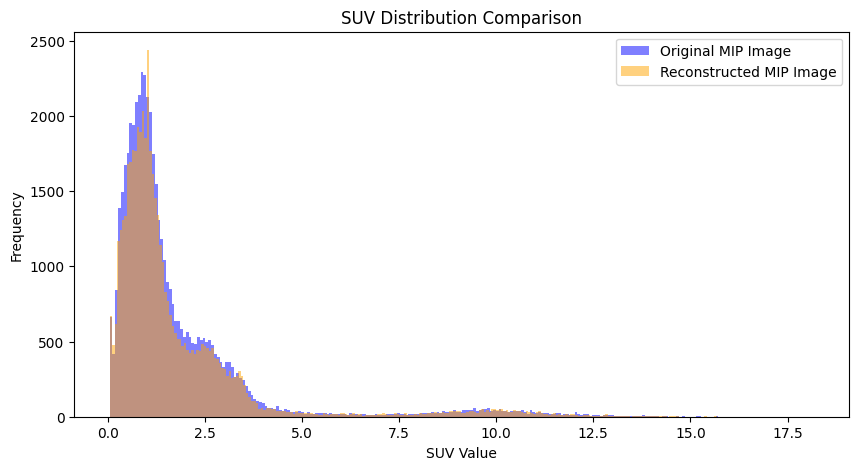

In [18]:
### Display SUV histograms per each image

# Filter values
true_filtered = true[true >= 0.05].cpu().numpy().flatten()
recon_filtered = recon[recon >= 0.05].cpu().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.hist(true_filtered, bins=250, alpha=0.5, label='Original MIP Image', color='blue')
plt.hist(recon_filtered, bins=250, alpha=0.5, label='Reconstructed MIP Image', color='orange')
plt.title('SUV Distribution Comparison')
plt.xlabel('SUV Value')
plt.ylabel('Frequency')
plt.legend()

### ANO Metadata (Constructor, Versions, Protocols)

In [145]:
import os
import pandas as pd
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_metadata/'
metadata_files = os.listdir(ROOT)

tags = [
    'ProtocolName', 'BodyPartExamined', 'Manufacturer',
    'ManufacturerModelName', 'SoftwareVersions'
]

metadata_dict = {tag: [] for tag in tags}
for s_metadata in tqdm(os.listdir(ROOT), position=0, leave=True):
    path = os.path.join(ROOT, s_metadata)
    df = pd.read_csv(path)

    for tag in tags:
        if tag in df.columns:
            value = df[tag].iloc[0]
            metadata_dict[tag].append(value if not pd.isna(value) else 'N/A')

# display unique values given the different tags
for tag in tags:
    unique_values = set(metadata_dict[tag])
    print(f"{tag} unique values: {unique_values}")

100%|██████████| 946/946 [00:01<00:00, 490.73it/s]

ProtocolName unique values: {'N/A'}
BodyPartExamined unique values: {'TEP FDG', 'MN101 TEP FLUORO', 'MN121 TEP2  FDG', 'MN132 TEP4 FLUOR', 'MN108 TEP2 FLUDE'}
Manufacturer unique values: {'GE MEDICAL SYSTEMS'}
ManufacturerModelName unique values: {'Discovery 710'}
SoftwareVersions unique values: {'53.00', 'pet_mfk.56'}


### Testing spherical mask extraction

In [111]:
import SimpleITK as sitk
from scipy.ndimage import distance_transform_edt
import numpy as np

def get_largest_inscribed_sphere_mask(sitk_mask, shrinkage_mm=0.0):
    mask_arr = sitk.GetArrayFromImage(sitk_mask)
    spacing = sitk_mask.GetSpacing() # (sx, sy, sz)
    
    # On inverse le spacing pour matcher l'ordre de numpy (sz, sy, sx)
    spacing_numpy = spacing[::-1]

    if mask_arr.sum() == 0:
        return sitk_mask

    # 2. Calcul de la Transformée de Distance Euclidienne (EDT)
    # sampling permet de gérer l'anisotropie (voxels non cubiques, fréquent en PET)
    edt_map = distance_transform_edt(mask_arr, sampling=spacing_numpy)

    # 3. Trouver le point max (Centre de la sphère) et le Rayon max
    max_radius = edt_map.max()
    
    # Optionnel: Réduire légèrement le rayon pour éviter tout contact avec le bord
    final_radius = max(0, max_radius - shrinkage_mm)
    
    if final_radius == 0:
        # Si la réduction supprime la sphère, on renvoie un masque vide
        sphere_arr = np.zeros_like(mask_arr, dtype=np.uint8)
    else:
        # Récupération des coordonnées du centre (en indices matriciels)
        # argmax renvoie l'index aplati, on le convertit en (z, y, x)
        center_idx = np.unravel_index(edt_map.argmax(), edt_map.shape)
        cz, cy, cx = center_idx

        # 4. Génération du masque de la sphère
        # On crée une grille de coordonnées pour calculer la distance de chaque point au centre
        zz, yy, xx = np.ogrid[:mask_arr.shape[0], :mask_arr.shape[1], :mask_arr.shape[2]]
        
        # Calcul de la distance euclidienne au carré pondérée par le spacing
        dist2 = (
            ((zz - cz) * spacing_numpy[0])**2 + 
            ((yy - cy) * spacing_numpy[1])**2 + 
            ((xx - cx) * spacing_numpy[2])**2
        )
        
        # Création du masque binaire : 1 si distance <= rayon, 0 sinon
        sphere_arr = (dist2 <= final_radius**2).astype(np.uint8)

    # 5. Reconversion en image SimpleITK
    sphere_mask_sitk = sitk.GetImageFromArray(sphere_arr)
    sphere_mask_sitk.CopyInformation(sitk_mask) # Copie origine, spacing, direction

    return sphere_mask_sitk

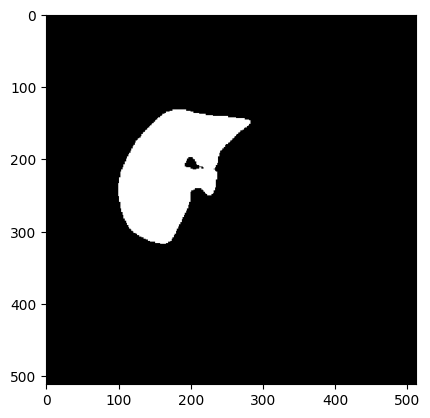

In [107]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

suv = sitk.ReadImage('../datasets/EARL/Ano_Nifti/9401152847m/PT_TEPTAPAC_Ano.nii.gz')
mask = sitk.ReadImage('../datasets/EARL/Ano_Nifti/9401152847m/liver.nii.gz')

mask_arr = sitk.GetArrayFromImage(mask)

plt.imshow(mask_arr[150, :, :], cmap='gray')

In [ ]:
mask_arr = sitk.GetArrayFromImage(mask)
spacing = mask.GetSpacing() # (sx, sy, sz)
spacing_numpy = spacing[::-1]

edt_map = distance_transform_edt(mask_arr, sampling=spacing_numpy)

In [135]:
max_radius = edt_map.max()
final_radius = max(0, max_radius - 1.0)

In [136]:
cz, cy, cx = np.unravel_index(edt_map.argmax(), edt_map.shape)
zz, yy, xx = np.ogrid[:mask_arr.shape[0], :mask_arr.shape[1], :mask_arr.shape[2]]

dist2 = (
    ((zz - cz) * spacing_numpy[0])**2 + 
    ((yy - cy) * spacing_numpy[1])**2 + 
    ((xx - cx) * spacing_numpy[2])**2
)
        
# Création du masque binaire : 1 si distance <= rayon, 0 sinon
sphere_arr = (dist2 <= final_radius ** 2).astype(np.uint8)

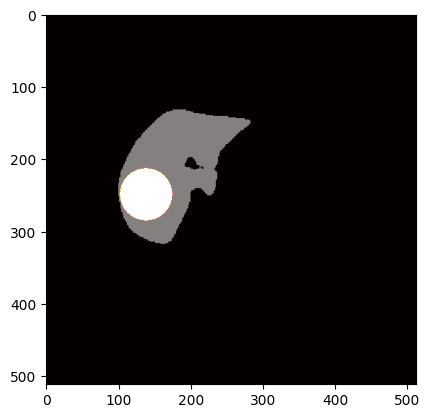

In [139]:
plt.imshow(mask_arr[150, :, :], cmap='gray')
plt.imshow(sphere_arr[150, :, :], cmap='hot', alpha=0.5)

In [140]:
sphere_mask_sitk = sitk.GetImageFromArray(sphere_arr)
sphere_mask_sitk.CopyInformation(mask) # Copie origine, spacing, direction

In [143]:
import SimpleITK as sitk
import os
from tqdm import tqdm

root = '../datasets/EARL/Ano_Nifti/'

pet_spacing, earl_spacing = set(), set()
for s in tqdm(os.listdir(root), position=0, leave=True, total=os.listdir(root).__len__()):
    subject_path = os.path.join(root, s)
    pet_img = sitk.ReadImage(os.path.join(subject_path, 'PT_TEPTAPAC_Ano.nii.gz'))
    earl_img = sitk.ReadImage(os.path.join(subject_path, 'PT_TEPTAPRECONEARL_Ano.nii.gz'))

    pet_spacing.add(pet_img.GetSpacing())
    earl_spacing.add(earl_img.GetSpacing())



100%|██████████| 943/943 [11:55<00:00,  1.32it/s]


### Calcul spacing median de tout le dataset

In [153]:
import os

root = '../datasets/EARL/Ano_Nifti/'

spet, searl = list(), list()
for s in tqdm(os.listdir(root), position=0, leave=True, total=os.listdir(root).__len__()):
    subject_path = os.path.join(root, s)
    pet_img_path = os.path.join(subject_path, 'PT_TEPTAPAC_Ano.nii.gz')
    earl_img_path = os.path.join(subject_path, 'PT_TEPTAPRECONEARL_Ano.nii.gz')

    pet_img = sitk.ReadImage(pet_img_path)
    earl_img = sitk.ReadImage(earl_img_path)

    spet.append(pet_img.GetSpacing())
    searl.append(earl_img.GetSpacing())

# display mode and median value for each
from scipy import stats
spet_mode = stats.mode(spet, axis=0).mode[0]
searl_mode = stats.mode(searl, axis=0).mode[0]
spet_median = np.median(np.array(spet), axis=0)
searl_median = np.median(np.array(searl), axis=0)

print(f"PET Spacing - Mode: {spet_mode}, Median: {spet_median}")
print(f"EARL Spacing - Mode: {searl_mode}, Median: {searl_median}")


100%|██████████| 943/943 [11:51<00:00,  1.33it/s]


### Test script SUV

In [47]:
import os
import sys
import logging
import datetime
from typing import Tuple

import pydicom
import numpy as np
import SimpleITK as sitk

from datetime import datetime


class NegativeDelay(Exception):
    """NegativeDelay"""

def delay_between_injection_and_scan(file_dcm: pydicom.FileDataset):
    try :
        injection_date_time = datetime.strptime(
            file_dcm.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime, 
            '%Y%m%d%H%M%S')
        print('injection date time:', injection_date_time)
    except ValueError:
        injection_date_time = datetime.strptime(
            file_dcm.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime,
            '%Y%m%d%H%M%S.%f')
        print('injection date time:', injection_date_time)
    try : 
        scan_date_time = datetime.strptime(file_dcm.AcquisitionDate + file_dcm.AcquisitionTime,
                                            '%Y%m%d%H%M%S')
        print('acquisition date time:', file_dcm.AcquisitionTime)
    except ValueError:
            scan_date_time = datetime.strptime(file_dcm.AcquisitionDate + file_dcm.AcquisitionTime,
                                                '%Y%m%d%H%M%S.%f')
            print('acquisition date time:', file_dcm.AcquisitionTime)
    return scan_date_time - injection_date_time


def convert_to_BQML(image_array, file_dcm):
    volume = file_dcm.PixelSpacing[0] * file_dcm.PixelSpacing[1] * file_dcm.SpacingBetweenSlices
    rescale_slope = 10**9 / (16.49 * file_dcm.NumberOfFrames * 2 * file_dcm.RotationInformationSequence[0].ActualFrameDuration * volume * 10**(-3))
    return rescale_slope*image_array

def compute_suv(input_image :sitk.Image, file_dcm: pydicom.FileDataset):
    image_array = sitk.GetArrayFromImage(input_image)

    units = file_dcm.get("Units", None)
    if units is None:
        image_array = convert_to_BQML(image_array, file_dcm)
        print('converted to BQML')

    # Retrieving metadata for SUV computation
    patient_weight = float(file_dcm.PatientWeight) * 1000
    print('patient weight (g):', patient_weight)
    half_life = float(file_dcm.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
    print('half life:', half_life)
    injected_dose = float(file_dcm.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)
    print('injected dose:', injected_dose)
    if file_dcm.Modality == "NM":
        injected_dose *=  1000000
        print('is NM')

    delay = delay_between_injection_and_scan(file_dcm).total_seconds()
    print('delay (s):', delay)
    if delay < 0:
        raise NegativeDelay("The delay between the radiopharmaceutical injection date and the scan "
                            "date is negative.This is not possible. There is an error in the "
                            "metadata.")

    decay = np.exp(-np.log(2) * ((delay) / half_life))
    print('decay factor:', decay)
    injected_dose_decay = injected_dose * decay
    print('injected dose after decay:', injected_dose_decay)
    factor = patient_weight / injected_dose_decay
    print('suv factor:', factor)

    suv_image_array = image_array * factor
    print('In code:', suv_image_array.min(), suv_image_array.max(), suv_image_array.mean())

    suv_image = sitk.GetImageFromArray(suv_image_array)
    # Copying metadata (importantly: space metadata) to the new Image
    suv_image.CopyInformation(input_image)

    return suv_image

def resample_itk(input_image: sitk.Image, direction: Tuple, origin:Tuple, size:Tuple, spacing:Tuple, interpolator=sitk.sitkBSpline):
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(interpolator)
    resample.SetOutputDirection(direction)
    resample.SetOutputOrigin(origin)
    resample.SetSize(size)
    resample.SetOutputSpacing(spacing)
    suv_image = resample.Execute(input_image)
    return suv_image

class MissingModalityError(Exception):
    """
    Exception to be raised when a modality is missing.
    """

class DicomToNifti:

    def __init__(
        self,
        ct_dicom_path: str,
        ct_nii_path: str,
        pet_dicom_path: str,
        pet_nii_path: str,
        spect_dicom_path: str,
        spect_nii_path: str
    ) -> None:

        """
        Initializes the DicomToNifti class with paths for DICOM and NIfTI files.

        Parameters:
            ct_dicom_path (str): Path to the CT DICOM files.
            ct_nii_path (str): Path to save the converted CT NIfTI file.
            pet_dicom_path (str): Path to the TEP DICOM files.
            pet_nii_path (str): Path to save the converted TEP NIfTI file.
            spect_dicom_path (str): Path to the SPECT DICOM files.
            spect_nii_path (str): Path to save the converted SPECT NIfTI file.
        """
        self.ct_dicom_path = ct_dicom_path
        self.ct_nii_path = ct_nii_path
        self.pet_dicom_path = pet_dicom_path
        self.pet_nii_path = pet_nii_path
        self.spect_dicom_path = spect_dicom_path
        self.spect_nii_path = spect_nii_path
        self.pt_new_size = None
        self.pt_new_orig= None
        self.pt_new_dir= None
        self.pt_spacing = None
        self.has_pet = False
        self.has_spect = False
        if (self.ct_dicom_path is None) or (self.ct_nii_path is None):
            raise MissingModalityError("Needs CT")
        if (self.pet_dicom_path is not None) and (self.pet_nii_path is not None):
            self.has_pet = True
        if (self.spect_dicom_path is not None) and (self.spect_nii_path is not None):
            self.has_spect = True
        if not(self.has_pet or self.has_spect):
            raise MissingModalityError("Needs at least a modality among PET and SPECT")
  
    def ct_dicom2nifti(self):

        """
        Converts CT DICOM files to NIfTI format and saves the image.
        """

        reader = sitk.ImageSeriesReader()
        ct_dicom_names = reader.GetGDCMSeriesFileNames(self.ct_dicom_path)
        reader.SetFileNames(ct_dicom_names)
        ct_image = reader.Execute()

        ct_image =resample_itk(ct_image, self.pt_new_dir, self.pt_new_orig,
                                 self.pt_new_size, self.pt_spacing)

        sitk.WriteImage(ct_image, self.ct_nii_path)

    def pet_dicom2nifti(self):
        """
        Converts TEP DICOM files to NIfTI format, computes the Standardized Uptake Value (SUV) for
        the PET image,resamples the image towards the destination space of CT, and saves the image.
        """

        reader = sitk.ImageSeriesReader()
        pet_dicom_names = reader.GetGDCMSeriesFileNames(self.pet_dicom_path)
        reader.SetFileNames(pet_dicom_names)
        pet_image = reader.Execute()

        ff = sorted(os.listdir(self.pet_dicom_path))[-1]
        print(ff)
        file_dcm = pydicom.dcmread(os.path.join(self.pet_dicom_path,ff),
                                   stop_before_pixels=True)
        
        print('Decay Correction:', file_dcm.get('DecayCorrection', 'N/A'))
        print('SeriesTime:', file_dcm.get('SeriesTime', 'N/A'))

        suv_image = compute_suv(pet_image, file_dcm)
        sitk.WriteImage(suv_image, self.pet_nii_path)

        self.pt_new_size = suv_image.GetSize()
        self.pt_new_orig= suv_image.GetOrigin()
        self.pt_new_dir= suv_image.GetDirection()
        self.pt_spacing = suv_image.GetSpacing()

    def spect_dicom2nifti(self):
        """
        Converts SPECT DICOM files to NIfTI format, computes the Standardized Uptake Value (SUV) 
        for the SPECT image,resamples the image towards the destination space of CT, and saves the 
        image.
        """

        reader = sitk.ImageFileReader()
        reader.SetFileName(str(os.path.join(self.spect_dicom_path, os.listdir(self.spect_dicom_path)[0])))
        sepct_image = reader.Execute()

        file_dcm = pydicom.dcmread(os.path.join(self.spect_dicom_path,os.listdir(self.spect_dicom_path)[0]),
                                   stop_before_pixels=True)

        suv_image = compute_suv(sepct_image, file_dcm)
        sitk.WriteImage(suv_image, self.spect_nii_path)

        self.pt_new_size = suv_image.GetSize()
        self.pt_new_orig= suv_image.GetOrigin()
        self.pt_new_dir= suv_image.GetDirection()
        self.pt_spacing = suv_image.GetSpacing()


dicom2nifti = DicomToNifti(
    '../datasets/EARL/Ano/9401152847m/CTTAP_Ano/', 
    './data/CT.nii.gz', 
    '../datasets/EARL/Ano/9401152847m/TEPTAPAC_Ano/', 
    './data/PT.nii.gz', 
    None, None
)
dicom2nifti.pet_dicom2nifti()

A1.rou.4e30.fr.rouen.S2.3626978.1_00298.DCM
Decay Correction: START
SeriesTime: 101731
patient weight (g): 72000.0
half life: 6586.2001953125
injected dose: 212370000.0
injection date time: 2018-12-10 09:15:00
acquisition date time: 101731
delay (s): 3751.0
decay factor: 0.6738390116759211
injected dose after decay: 143103190.90961537
suv factor: 0.000503133434987313
In code: 0.0 41.48448750824544 0.11585721943622304


### Plotting features

In [10]:
import os
import pandas as pd
from tqdm import tqdm

root = './data/PET-EARL/Ano_Nifti_resampled/'

fuse = list()
for subj in tqdm(os.listdir(root), position=0, leave=True, total=os.listdir(root).__len__()):
    sub_path = os.path.join(root, subj)
    subj_meta = os.path.join(sub_path, 'liver_sphere_radiomics.csv')

    if not os.path.exists(subj_meta):
        continue 
    
    dataframe = pd.read_csv(subj_meta)
    fuse.append(dataframe)

final_dataframe = pd.concat(fuse, axis=0)
final_dataframe

100%|██████████| 915/915 [00:03<00:00, 247.21it/s]


,Subject_ID,Modality,Image_Filename,Mask_Filename,ROI_type,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,...,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,9401169231m,EARL,EARL_TEPTAPRECONEARL_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,55.110555,0.185983,0.006085,0.054701,0.001149,44.542192,0.002576,1.593987,0.025475,0.012853
1,9401169231m,PET,PET_TEPTAPAC_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,56.108965,0.199155,0.008070,0.093101,0.001652,28.211582,0.002708,2.820182,0.018068,0.023239
0,9401168283m,EARL,EARL_TEPTAPRECONEARL_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,12.276243,0.060389,0.010716,0.233057,0.000788,8.277102,0.002725,9.305084,0.011088,0.070247
1,9401168283m,PET,PET_TEPTAPAC_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,11.790972,0.061193,0.010503,0.227036,0.000752,7.796522,0.002968,8.843804,0.011435,0.074377
0,9401173316m,EARL,EARL_TEPTAPRECONEARL_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,15.790352,0.077584,0.010898,0.215244,0.000915,8.542284,0.003152,8.998919,0.012875,0.077419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,9401163387m,PET,PET_TEPTAPAC_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,6.070278,0.045486,0.017248,0.612314,0.000836,4.548835,0.003784,15.370554,0.017809,0.132186
0,9401186753m,EARL,EARL_TEPTAPRECONEARL_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,34.433324,0.134186,0.008923,0.103843,0.001715,18.529970,0.002724,4.547341,0.014830,0.036341
1,9401186753m,PET,PET_TEPTAPAC_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,34.007862,0.142008,0.008438,0.092567,0.001668,18.558555,0.002847,4.457336,0.016471,0.037094
0,9401179679m,EARL,EARL_TEPTAPRECONEARL_Ano.nii.gz,liver.nii.gz,Sphere_20.0mm,v3.1.0,1.23.4,2.4.0,1.4.1,3.8.10,...,44.504026,0.161593,0.006832,0.062297,0.001530,27.081472,0.002491,2.842778,0.014348,0.021867


In [18]:
[c for c in final_dataframe.columns if 'shape' in c]

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume']

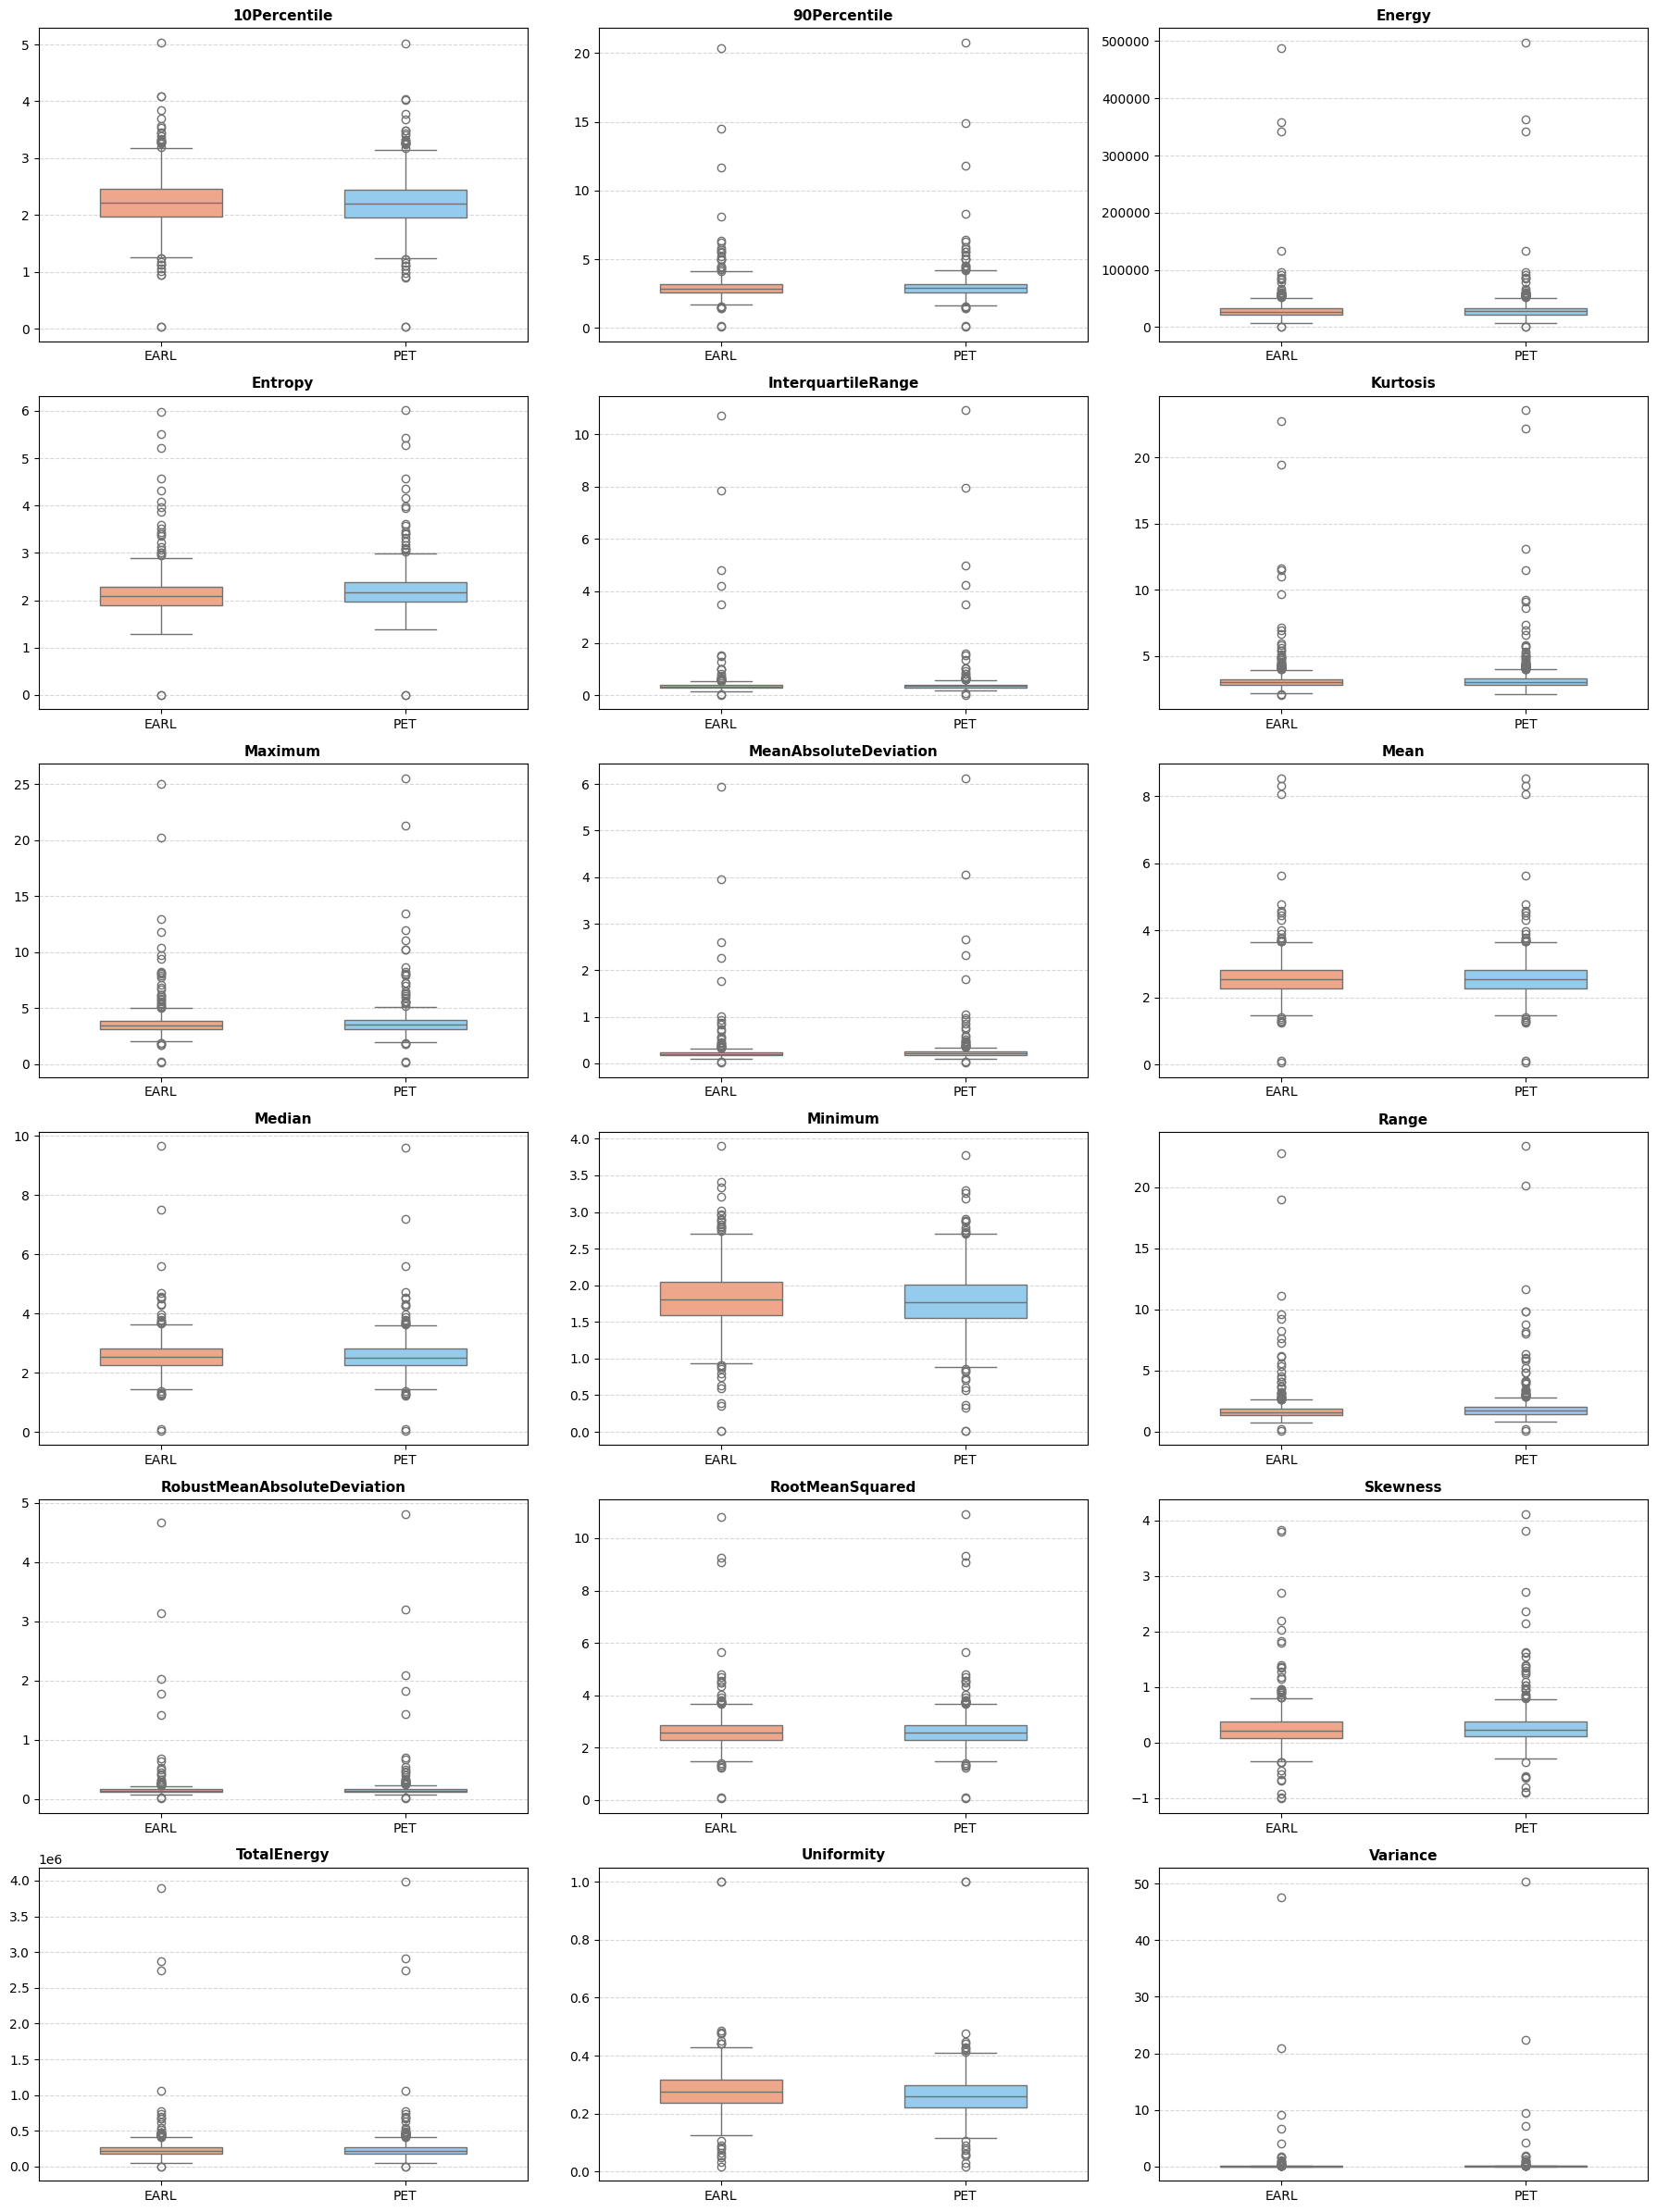

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Liste des features First Order
firstorder_features = [
    'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 
    'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 
    'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 
    'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 
    'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 
    'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 
    'original_firstorder_Variance'
]

# 2. Configuration de la figure (6 lignes x 3 colonnes = 18 plots)
n_cols = 3
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 24)) # Grand format vertical
axes = axes.flatten() # Aplatir pour itérer facilement

# Palette de couleurs distincte
my_palette = {"PET": "#87CEFA", "EARL": "#FFA07A"} # Bleu vs Orange

for i, feature in enumerate(firstorder_features):
    ax = axes[i]
    
    # --- Création du Boxplot ---
    sns.boxplot(
        data=final_dataframe,
        x="Modality",
        y=feature,
        ax=ax,
        palette=my_palette,
        showfliers=True, # Mettre True si vous voulez voir les points extrêmes
        width=0.5,
        hue="Modality"
    )
    
    # --- Esthétique ---
    # Titre propre (on retire le préfixe répétitif)
    short_name = feature.replace('original_firstorder_', '')
    ax.set_title(short_name, fontsize=11, fontweight='bold')
    
    # Nettoyage des axes
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Optionnel : Ajouter une grille légère
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Suppression des subplots vides s'il y en a (ici 18 features pour 18 cases, donc 0 vide)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Pour sauvegarder
# plt.savefig("comparaison_pet_earl_firstorder.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_57333/1385681039.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


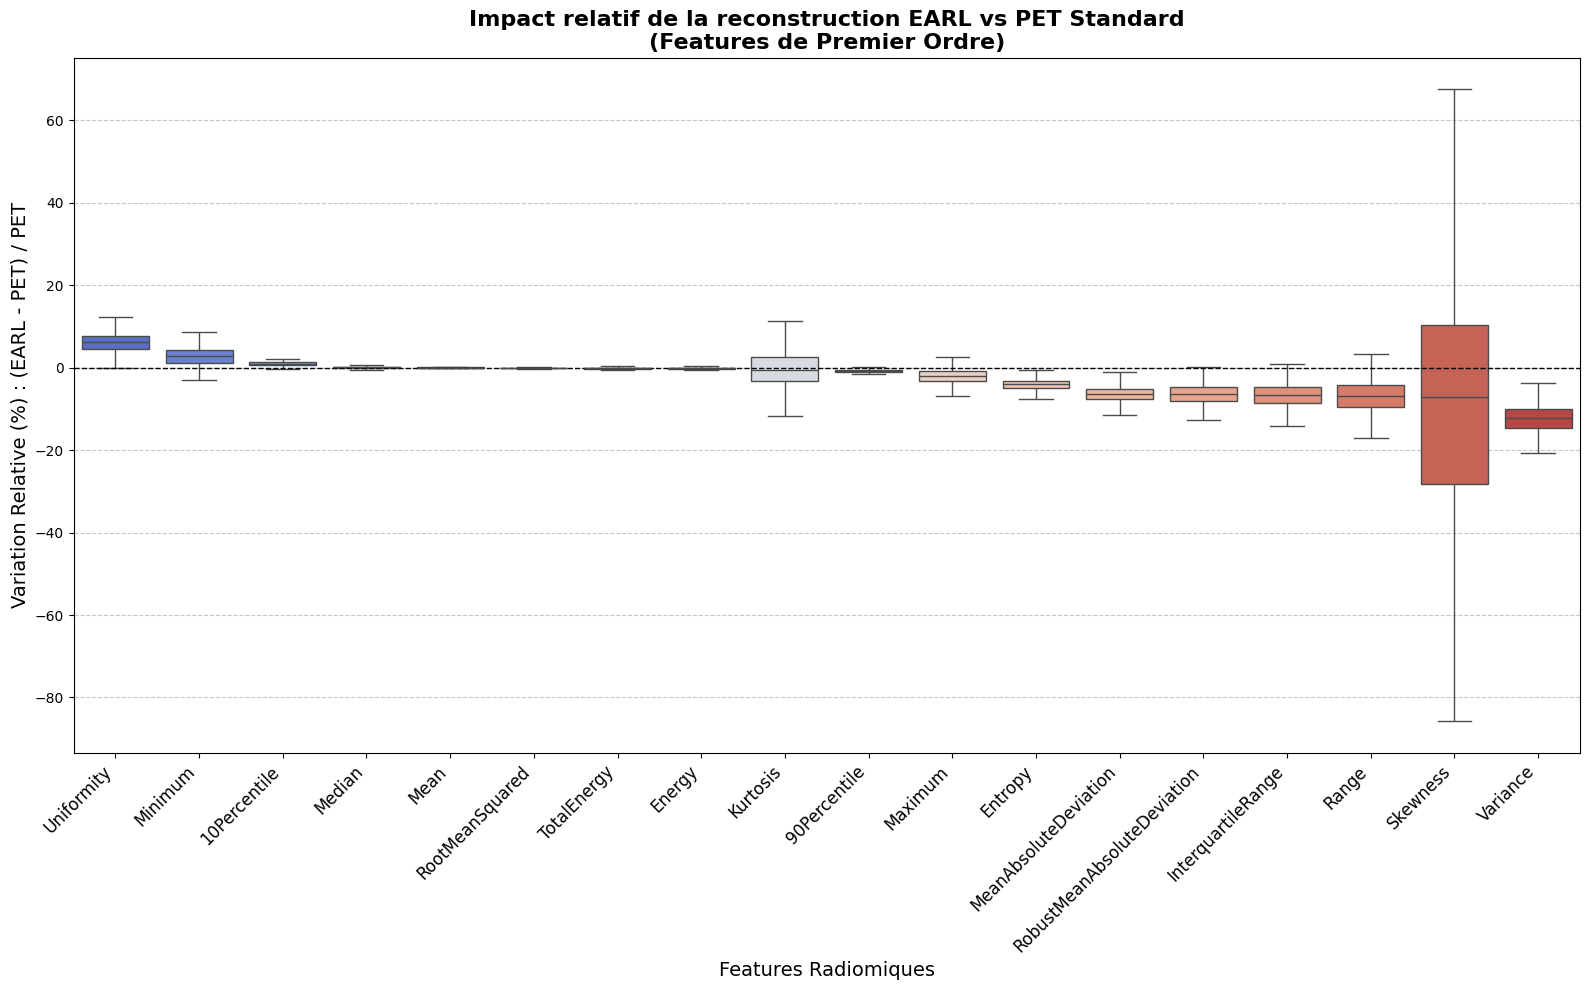

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

features_cols = [c for c in final_dataframe.columns if 'original_firstorder' in c]

df_pet = final_dataframe[final_dataframe['Modality'] == 'PET'].set_index('Subject_ID')[features_cols]
df_earl = final_dataframe[final_dataframe['Modality'] == 'EARL'].set_index('Subject_ID')[features_cols]

common_subjects = df_pet.index.intersection(df_earl.index)
df_pet = df_pet.loc[common_subjects]
df_earl = df_earl.loc[common_subjects]

# Calcul de la différence relative (%)
# Attention aux divisions par zéro : si PET est 0, cela crée des infinis.
# En radiomics FirstOrder, c'est rare sauf pour Minimum/Median=0.
df_diff_percent = ((df_earl - df_pet) / df_pet.abs()) * 100 
# Note: .abs() au dénominateur est important si vous avez des valeurs négatives (ex: Skewness),
# pour garder le signe correct de la variation.

# 2. Mise en forme pour le plot (Melt)
# On transforme en format long : une ligne par feature par patient
df_plot = df_diff_percent.melt(var_name='Feature', value_name='Relative_Difference_Percent')

# Nettoyage des noms de features pour l'affichage
df_plot['Feature'] = df_plot['Feature'].str.replace('original_firstorder_', '')

# 3. Création du Boxplot Global
plt.figure(figsize=(16, 10))

# On trie les features par médiane décroissante pour un affichage plus lisible
sorted_index = df_plot.groupby('Feature')['Relative_Difference_Percent'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df_plot,
    x='Feature',
    y='Relative_Difference_Percent',
    order=sorted_index, # Tri intelligent
    palette="coolwarm", # Rouge = Augmentation, Bleu = Diminution
    showfliers=False # On cache les outliers extrêmes pour garder l'échelle lisible
)

# Ligne de référence à 0% (Aucun changement)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Esthétique
plt.title("Impact relatif de la reconstruction EARL vs PET Standard\n(Features de Premier Ordre)", fontsize=16, fontweight='bold')
plt.ylabel("Variation Relative (%) : (EARL - PET) / PET", fontsize=14)
plt.xlabel("Features Radiomiques", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# plt.savefig("variation_relative_earl.png", dpi=300)

Nombre de features GLCM trouvées : 24


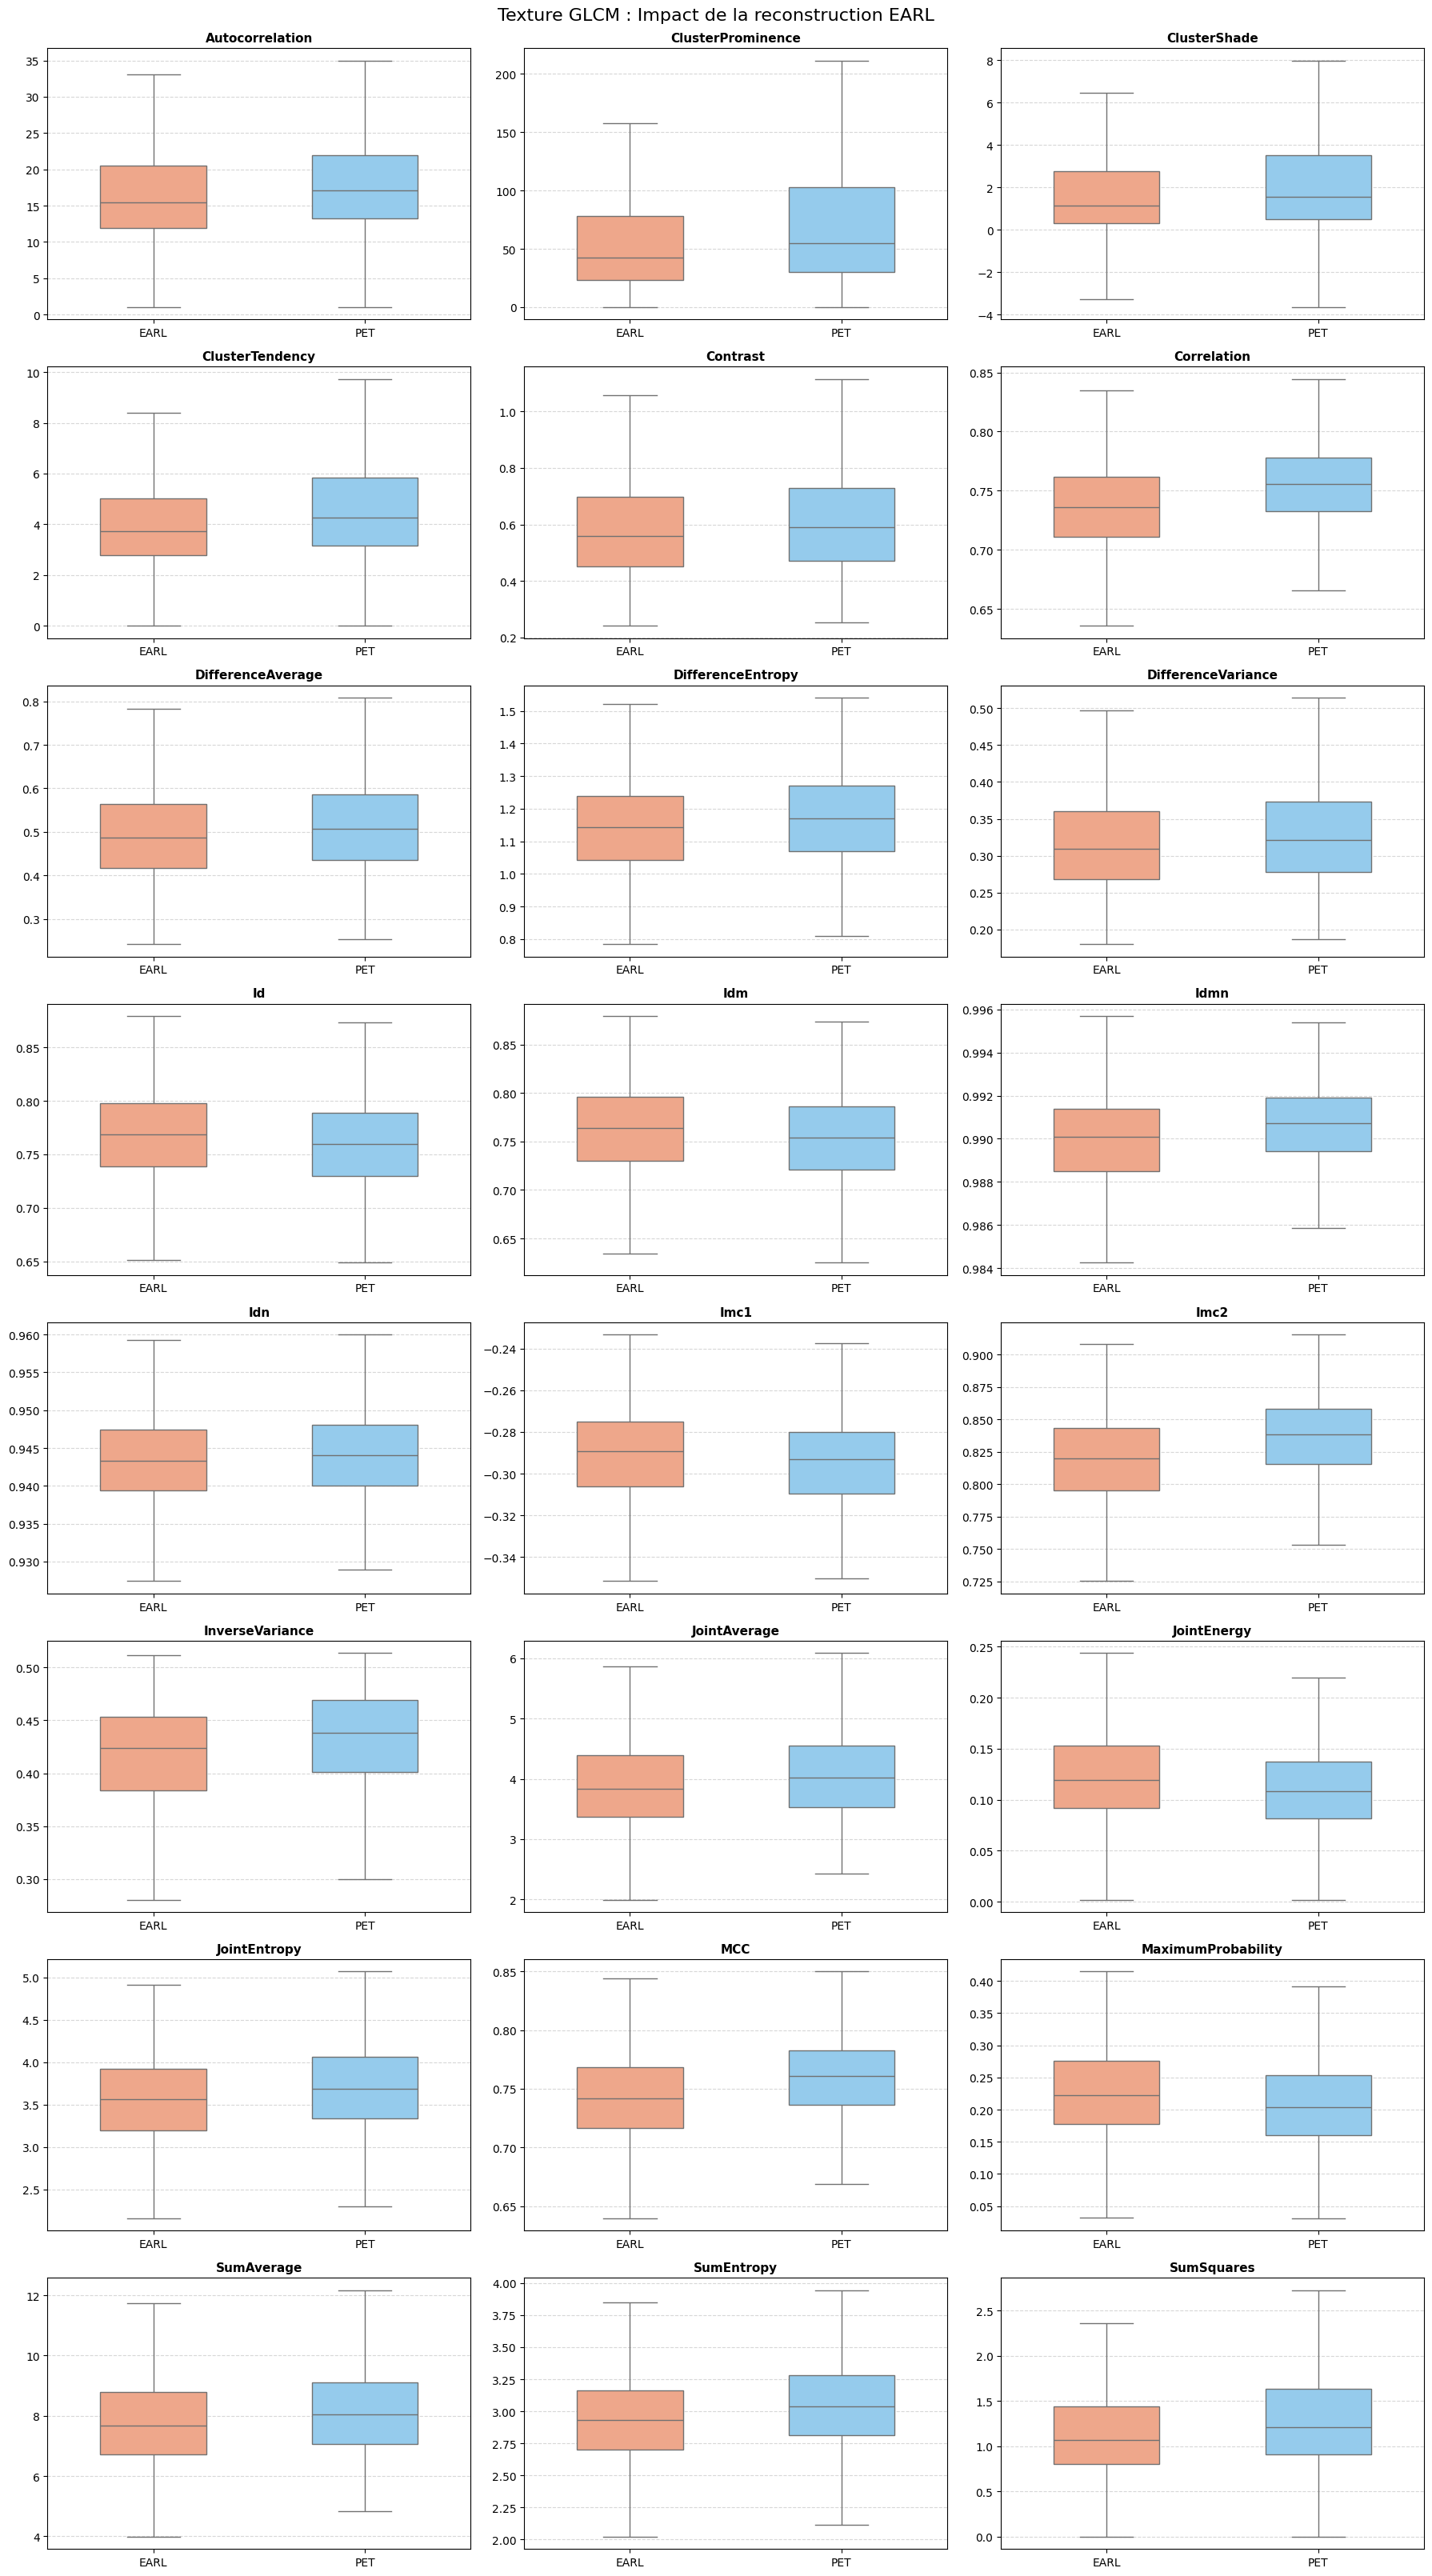

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Identification des features GLCM dans votre dataframe
# PyRadiomics préfixe par 'original_glcm_'
glcm_features = [col for col in final_dataframe.columns if 'original_glcm_' in col]

# On filtre celles qui sont souvent redondantes ou moins parlantes si vous voulez simplifier
# Mais affichons tout pour commencer.
print(f"Nombre de features GLCM trouvées : {len(glcm_features)}")

# 2. Configuration de la grille
# On adapte le nombre de lignes selon le nombre de features trouvées
n_cols = 3
n_rows = int(np.ceil(len(glcm_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Palette : PET en Bleu (Froid/Bruit), EARL en Orange (Chaud/Lissé)
my_palette = {"PET": "#87CEFA", "EARL": "#FFA07A"}

for i, feature in enumerate(glcm_features):
    ax = axes[i]
    
    # Boxplot
    sns.boxplot(
        data=final_dataframe,
        x="Modality",
        y=feature,
        ax=ax,
        palette=my_palette,
        showfliers=False, # On cache les outliers pour mieux voir la médiane et les quartiles
        width=0.5,
        hue="Modality"
    )
    
    # Titre nettoyé
    short_name = feature.replace('original_glcm_', '')
    ax.set_title(short_name, fontsize=11, fontweight='bold')
    
    # Nettoyage
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Suppression des cases vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Texture GLCM : Impact de la reconstruction EARL", y=1.005, fontsize=16)
plt.show()

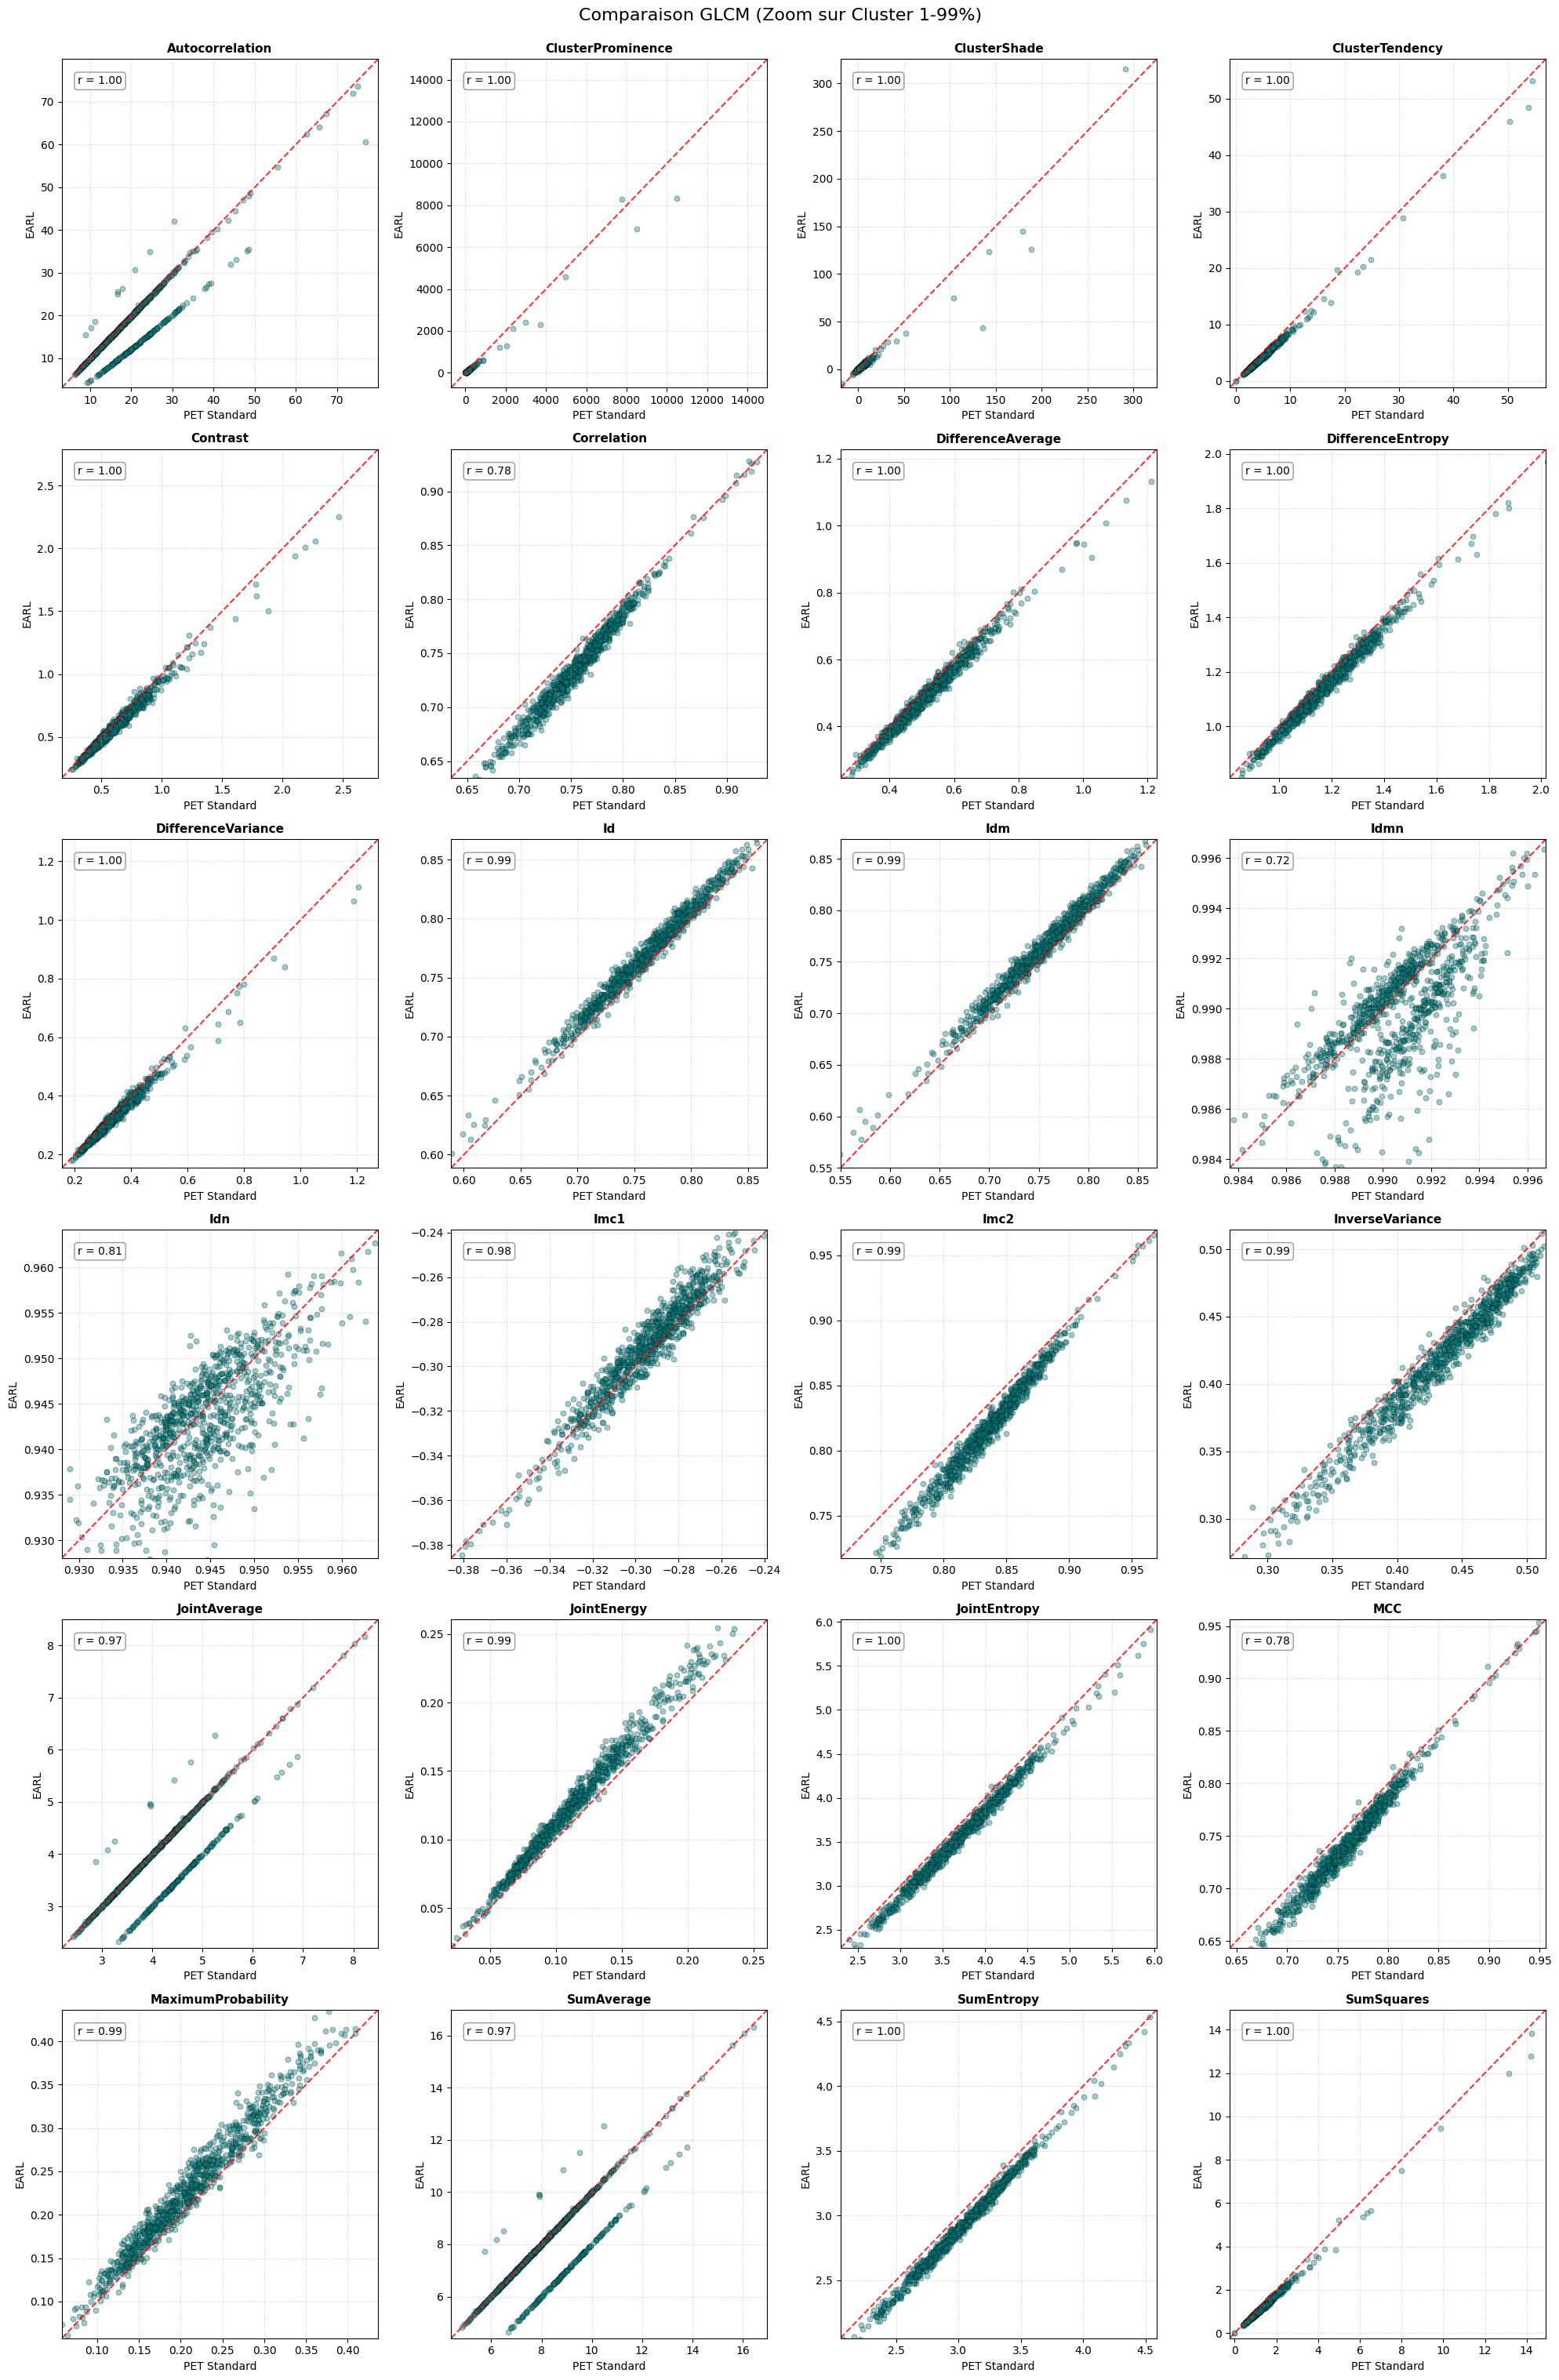

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 1. Sélection des features
glcm_features = [col for col in final_dataframe.columns if 'original_glcm_' in col]
glcm_features.sort()

# 2. Préparation des données
df_pet = final_dataframe[final_dataframe['Modality'] == 'PET'].set_index('Subject_ID')[glcm_features]
df_earl = final_dataframe[final_dataframe['Modality'] == 'EARL'].set_index('Subject_ID')[glcm_features]
common_subjects = df_pet.index.intersection(df_earl.index)

# 3. Grille
n_cols = 4
n_rows = int(np.ceil(len(glcm_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Paramètres de zoom (ex: on garde 98% des données centrales)
LOWER_PERCENTILE = 1.0 
UPPER_PERCENTILE = 99.0

for i, feature in enumerate(glcm_features):
    ax = axes[i]
    
    # Récupération des données
    x = df_pet.loc[common_subjects, feature]
    y = df_earl.loc[common_subjects, feature]
    
    # Scatter Plot
    # alpha plus faible (0.4) pour mieux voir la densité du cluster central
    ax.scatter(x, y, alpha=0.4, c='teal', edgecolors='k', linewidth=0.5, s=25)
    
    # --- ZOOM INTELLIGENT ---
    # On combine X et Y pour trouver l'échelle commune
    all_vals = np.concatenate([x, y])
    
    # Calcul des bornes robustes (on ignore les 1% extrêmes en bas et en haut)
    vmin = np.percentile(all_vals, LOWER_PERCENTILE)
    vmax = np.percentile(all_vals, UPPER_PERCENTILE)
    
    # On ajoute une toute petite marge (5%) autour de ce cluster
    margin = (vmax - vmin) * 0.05
    lim_min = vmin - margin
    lim_max = vmax + margin
    
    # Ligne d'identité (y=x) limitée à la zone visible
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', alpha=0.8, linewidth=1.5, label='Identité')
    
    # Application des limites
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    
    # Calcul Corrélation
    corr, _ = pearsonr(x, y)
    
    # Esthétique
    short_name = feature.replace('original_glcm_', '')
    ax.set_title(short_name, fontsize=11, fontweight='bold')
    ax.set_xlabel('PET Standard')
    ax.set_ylabel('EARL')
    
    ax.text(0.05, 0.95, f'r = {corr:.2f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    ax.grid(True, linestyle=':', alpha=0.6)

# Nettoyage
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Comparaison GLCM (Zoom sur Cluster 1-99%)", y=1.01, fontsize=16)
plt.show()

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed

# --- Configuration ---
root_dir = './data/PET-EARL/Ano_Nifti_resampled/'
suv_max_range = 30.0  # On regarde les SUV de 0 à 30 (au-delà c'est rare/tumeur très chaude)
n_bins = 3000         # Précision de 0.1 SUV (30 / 300)
bins = np.linspace(0, suv_max_range, n_bins + 1)
centers = (bins[:-1] + bins[1:]) / 2

# Accumulateurs pour la somme des fréquences
total_hist_pet = np.zeros(n_bins)
total_hist_earl = np.zeros(n_bins)
count_subjects = 0

subjects = sorted(os.listdir(root_dir))

print("Calcul des histogrammes cumulés...")

def process_subject(subj):
    subj_path = os.path.join(root_dir, subj)
    
    if not os.path.isdir(subj_path):
        return None

    # Trouver les fichiers
    files = os.listdir(subj_path)
    # Filtre robuste (à adapter selon vos noms exacts)
    pt_file = next((f for f in files if f.startswith('PET') and 'EARL' not in f and f.endswith('.nii.gz')), None)
    earl_file = next((f for f in files if f.startswith('EARL') and f.endswith('.nii.gz')), None)
    
    # On a besoin d'un masque (foie ou corps entier) ? 
    # Si on prend tout l'image, on aura énormément de zéros (air).
    # IDÉALEMENT : Il faut utiliser un masque (ex: masque du corps ou au moins > 0.1 SUV)
    
    if pt_file and earl_file:
        try:
            # Chargement (On lit juste le tableau numpy, pas besoin de l'image SITK complète)
            # Note: SimpleITK est rapide pour ça
            img_pet = sitk.ReadImage(os.path.join(subj_path, pt_file))
            arr_pet = sitk.GetArrayViewFromImage(img_pet).flatten()
            
            img_earl = sitk.ReadImage(os.path.join(subj_path, earl_file))
            arr_earl = sitk.GetArrayViewFromImage(img_earl).flatten()
            
            # --- FILTRAGE ESSENTIEL ---
            # On ignore le fond (air) et les valeurs négatives (artefacts bspline)
            # On ne garde que ce qui est biologiquement significatif (> 0.5 SUV par exemple)
            mask_pet = arr_pet < suv_max_range
            mask_earl = arr_earl < suv_max_range
            
            vals_pet = arr_pet[mask_pet]
            vals_earl = arr_earl[mask_earl]
            
            # Calcul histogramme local
            # density=False car on veut sommer les occurences
            hist_p, _ = np.histogram(vals_pet, bins=bins)
            hist_e, _ = np.histogram(vals_earl, bins=bins)
            
            return hist_p, hist_e
            
        except Exception as e:
            print(f"Erreur sur {subj}: {e}")
            return None
        
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count() // 2) as executor:
    futures = {executor.submit(process_subject, subj): subj for subj in subjects}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Traitement des sujets"):
        result = future.result()
        if result is not None:
            hist_p, hist_e = result
            total_hist_pet += hist_p
            total_hist_earl += hist_e



Calcul des histogrammes cumulés...


Traitement des sujets:   0%|          | 2/915 [00:10<1:04:39,  4.25s/it]

/tmp/ipykernel_290687/2720970504.py:3: RuntimeWarning: invalid value encountered in divide
  total_hist_pet = total_hist_pet / total_hist_pet.sum()
/tmp/ipykernel_290687/2720970504.py:4: RuntimeWarning: invalid value encountered in divide
  total_hist_earl = total_hist_earl / total_hist_earl.sum()


ValueError: Axis limits cannot be NaN or Inf

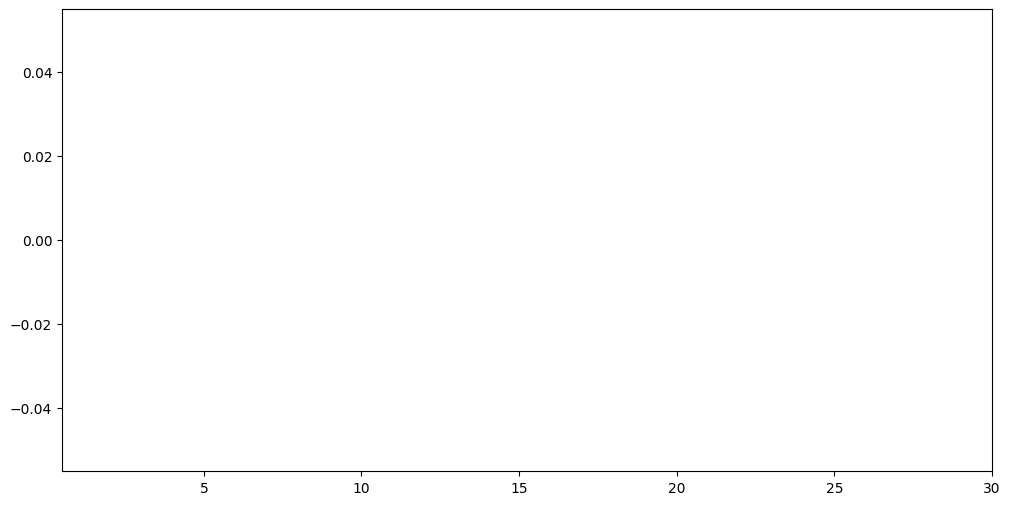

In [18]:
# --- Normalisation ---
# Pour comparer, on transforme en densité de probabilité (l'aire sous la courbe = 1)
total_hist_pet = total_hist_pet / total_hist_pet.sum()
total_hist_earl = total_hist_earl / total_hist_earl.sum()

# --- Affichage ---
plt.figure(figsize=(12, 6))

plt.bar(centers, total_hist_pet, width=0.2, alpha=1.0, label='PET Standard', color='blue')
plt.bar(centers, total_hist_earl, width=0.2, alpha=0.5, label='EARL Reconstruction', color='red')
plt.xlim(0.5, 30)
plt.ylim(0, max(total_hist_pet.max(), total_hist_earl.max()) * 1.1)
plt.xlabel('SUV')
plt.ylabel('Densité de probabilité')
plt.title('Histogramme Cumulé des SUV : PET Standard vs EARL Reconstruction')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


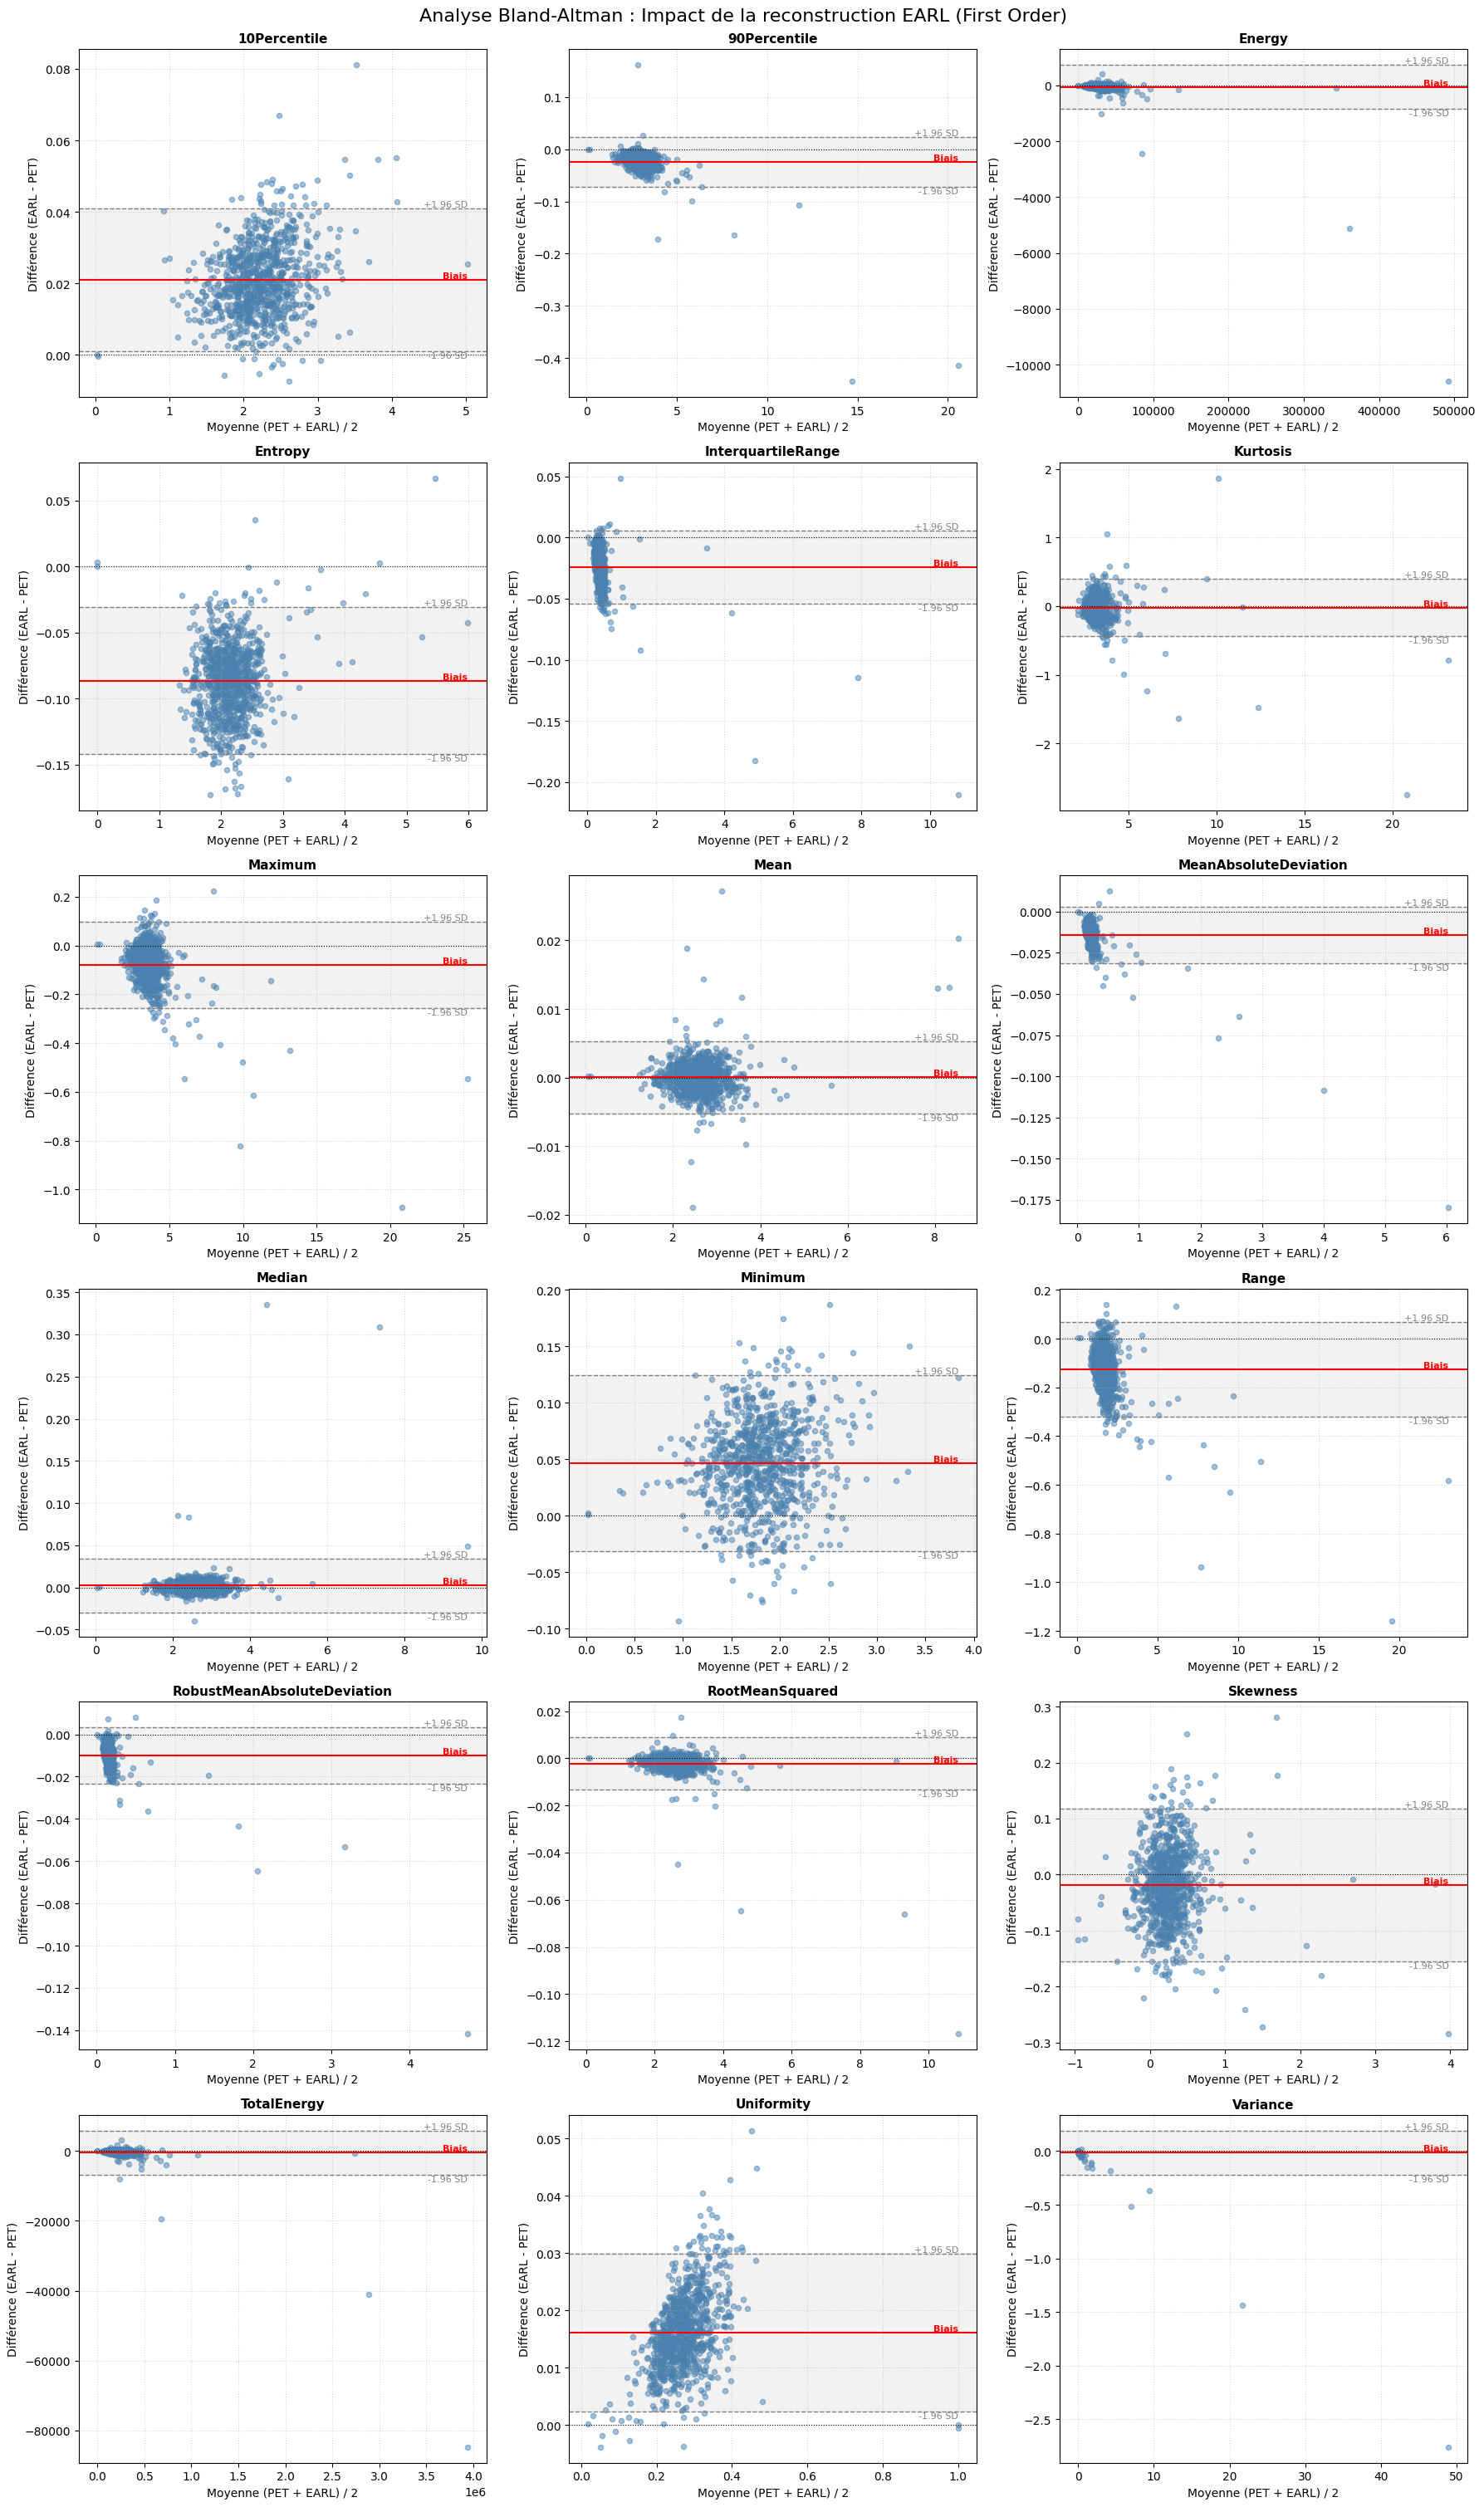

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Sélection des features First Order
features = [c for c in final_dataframe.columns if 'original_firstorder_' in c]
features.sort() # Pour un ordre constant

# 2. Préparation des données appariées
df_pet = final_dataframe[final_dataframe['Modality'] == 'PET'].set_index('Subject_ID')[features]
df_earl = final_dataframe[final_dataframe['Modality'] == 'EARL'].set_index('Subject_ID')[features]
common_subjects = df_pet.index.intersection(df_earl.index)

# 3. Configuration de la grille (3 colonnes)
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Récupération des valeurs
    data_pet = df_pet.loc[common_subjects, feature]
    data_earl = df_earl.loc[common_subjects, feature]
    
    # --- CALCULS BLAND-ALTMAN ---
    # Axe X : La Moyenne des deux mesures ((A + B) / 2)
    means = (data_pet + data_earl) / 2
    
    # Axe Y : La Différence (EARL - PET) -> "Comment EARL dévie de PET ?"
    diffs = data_earl - data_pet
    
    # Statistiques
    bias = np.mean(diffs)
    sd = np.std(diffs)
    upper_loa = bias + 1.96 * sd # Limit of Agreement (+1.96 SD)
    lower_loa = bias - 1.96 * sd # Limit of Agreement (-1.96 SD)
    
    # --- PLOT ---
    # Nuage de points
    ax.scatter(means, diffs, c='steelblue', alpha=0.5, s=20)
    
    # Lignes de référence
    # 1. Biais (Moyenne des différences) - Ligne continue
    ax.axhline(bias, color='red', linestyle='-', linewidth=1.5, label=f'Biais ({bias:.2f})')
    
    # 2. Limites d'accord (LoA) - Lignes pointillées
    ax.axhline(upper_loa, color='gray', linestyle='--', linewidth=1, label=f'+1.96 SD ({upper_loa:.2f})')
    ax.axhline(lower_loa, color='gray', linestyle='--', linewidth=1, label=f'-1.96 SD ({lower_loa:.2f})')
    
    # Zone de confiance 95% (Optionnel mais joli)
    ax.axhspan(lower_loa, upper_loa, color='gray', alpha=0.1)
    
    # Ligne Zéro (Idéal)
    ax.axhline(0, color='black', linewidth=0.8, linestyle=':')
    
    # --- ESTHÉTIQUE ---
    short_name = feature.replace('original_firstorder_', '')
    ax.set_title(short_name, fontsize=11, fontweight='bold')
    ax.set_xlabel('Moyenne (PET + EARL) / 2')
    ax.set_ylabel('Différence (EARL - PET)')
    
    # Annotations des valeurs sur le graphe (à droite)
    # On place le texte à x = max(means), y = les lignes
    x_pos = np.max(means)
    ax.text(x_pos, upper_loa, f'+1.96 SD', va='bottom', ha='right', fontsize=8, color='gray')
    ax.text(x_pos, lower_loa, f'-1.96 SD', va='top', ha='right', fontsize=8, color='gray')
    ax.text(x_pos, bias, f'Biais', va='bottom', ha='right', fontsize=8, color='red', fontweight='bold')
    
    ax.grid(True, linestyle=':', alpha=0.5)

# Suppression des cases vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Analyse Bland-Altman : Impact de la reconstruction EARL (First Order)", y=1.005, fontsize=16)
plt.show()